In [1]:
# Import MAESTRI dataset

# Import correspondence tables

# Match ISIC, WZ and SSIC codes to NACE codes

## ISIC doesn't need NLP

## WZ and SSIC have multiple codes for a given NACE code

### Use a LLM to find the best match given extra info

### 0. Utilities

#### Imports

In [2]:
import numpy as np
import pandas as pd
import re
import ollama
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from utils.constants import DIFF_THRESHOLD, EXPORTS_PATH
from utils.types import IndustryStandard, IndustryCode
from utils.inference import read_inference
from utils.maestri import read_maestri, NON_NACE_STDS, MAESTRI_ROLES, get_maestri_code_col, MAESTRI_DESC_COL
from utils.similarity import str_to_codes, get_similarity, get_similarity_col

In [4]:
class NACECompany:
    def __init__(self, code: str, desc: str):
        self.code = IndustryCode(IndustryStandard.NACE, code)
        self.description = desc

### 1. Reading the MAESTRI dataset

#### Importing the spreadsheet

In [5]:
inference_dfs = read_inference()
NACE_df = inference_dfs[IndustryStandard.NACE]

In [6]:
# Read the MAESTRI dataset as a DataFrame
maestri_dfs = read_maestri()

def simplify_nace_code_str(string):
    if "," in string:
        return string.split(",")[0]
    
    return string.split(";")[0]

for i in range(len(MAESTRI_ROLES)):
    role = MAESTRI_ROLES
    nace_col = get_maestri_code_col(IndustryStandard.NACE)

    maestri_dfs[i][nace_col] = maestri_dfs[i][nace_col].map(simplify_nace_code_str)

In [7]:
maestri_dfs[0].head()

,Company description,NACE code,ISIC code,WZ code,SSIC code
0,Refinery,1920,1920,19200,19201
1,Refinery,1920,1920,19200,19201
2,Steelworks,2410,2410,24520,24310
3,Steelworks,2410,2410,24520,24310
4,Cement production,2351,2394,23510;23650;23610,23940


In [9]:
def get_level(code) -> int:
    df = inference_dfs[code.std]
    
    if code.value in df.index:
        return df.loc[code.value, "Level"]

    return None

def get_children(code):
    df = inference_dfs[code.std]
    
    if code.value == "" or code.value in df.index:
        return [IndustryCode(code.std, value) for value in df[df["Parent"] == code.value].index]

    return []

def get_parent(code, level=-1):
    df = inference_dfs[code.std]
    
    if code.value in df.index:
        l = df.loc[code.value, "Level"]

        if level >= l:
            return None
        
        v = df.loc[code.value, "Parent"]

        # Level == -1 (immediate parent)
        if level == -1:
            return IndustryCode(code.std, v)
        
        while l > level:
            l = df.loc[v, "Level"]

            if l != level:
                v = df.loc[v, "Parent"]
        
        return IndustryCode(code.std, v)

    # print(code.value)
    return None

# Evaluate the highest common level (HCL)
def get_common_parent(code, other_std):
    # from_df = inference_dfs[code.std]
    to_df = inference_dfs[other_std]
    level = get_level(code)
    
    if level == 1:
        return IndustryCode(other_std, "")
    
    parent = get_parent(code)
    
    while parent.value not in to_df.index:
        # print(std.value + ": " + c.value)
        parent = get_parent(parent)
        # print(parent.value)
    
    parent = IndustryCode(other_std, parent.value)

    while len(get_children(parent)) == 1 and get_level(parent) < get_level(code) - 1:
        parent = get_children(parent)[0]
    
    return parent

In [30]:
def get_detailed_code_str(code):
	df = inference_dfs[code.std].copy()
    
	if code.value in df.index:
		series = df.loc[code.value]
		series = series[series.index[~series.index.isin(["Level", "Parent", "ISIC code"])]]
		string = f"{code.std.value} Code: {series.name}\n"

		for col in series.index:
			if series[col] != "":
				text = re.sub(r"\s*\(\d+\.\d+(?:\,\s*\d+\.\d+)*\)", "", series[col])
				text = text.replace("\n", "")
				
				string += f"{col}: {text}\n"
						
		return string.strip()

	return None

def get_detailed_company_str(company):
	return f"Company description: {company.description}\n{get_detailed_code_str(company.code)}"

def get_match_prompt(company, to_codes):
    from_std = company.code.std
    to_std = to_codes[0].std
    
    prompt = f"Classify the company below given its {from_std.value} code and description to the most similar" \
			 f" of the following {to_std.value} codes using their descriptions, examples and exclusions. When" \
       		 f" returning the result as JSON, the keys for the given code should be '{from_std.value}' and for" \
    		 f" the matched code as '{to_std.value}':\n\n{get_detailed_company_str(company)}"
    
    for code in to_codes:
        prompt += "\n\n" + get_detailed_code_str(code)
    
    return prompt

def query_llm(company, to_codes):
	prompt = get_match_prompt(company, to_codes)
	to_std = to_codes[0].std
	print("Prompt: " + prompt)

	response = ollama.generate(model='llama3', prompt=prompt, format="json", options={"temperature": 0.3})
	response = json.loads(response["response"])
	# print(f"Given {from_code.std.value} code: {from_code.value}, matched {to_std.value} code: {response[to_std.value]}")

	# return IndustryCode(to_std, "")
	return IndustryCode(to_std, response[to_std.value])

In [11]:
# def get_match_prompt_from_common_parent(from_code, to_std):
#     common_parent = get_common_parent(from_code, to_std)
#     return get_match_prompt(from_code, get_children(common_parent))

# c = IndustryCode(IndustryStandard.SSIC, "01")
# print(get_match_prompt_from_common_parent(c, IndustryStandard.WZ))

### 2. Obtaining similarity scores for validation

In [12]:
def get_match(company, to_std, to_guesses_str):
	from_code = company.code
	# print(f"'{from_code.std.value}', '{from_code.value}', '{to_std.value}', '{to_guesses_str}'")

	if to_std == IndustryStandard.ISIC:
		return IndustryCode(IndustryStandard.ISIC, NACE_df.loc[from_code.value, "ISIC code"])

	to_codes = [code for code in str_to_codes(to_guesses_str, to_std) if get_parent(code, level=1).value == get_parent(from_code, level=1).value]

	if len(to_codes) == 0:
		# Find common parent
		common_parent = get_common_parent(from_code, to_std)
		match = common_parent

		while len(get_children(match)) > 0:
			to_codes = get_children(match)

			# If there is only one child, that is assumed to be the match
			if len(to_codes) == 1:
				match = to_codes[0]

			# If there are multiple children, 
			elif len(to_codes) > 1:
				match = query_llm(company, to_codes)

		return match

	elif len(to_codes) == 1:
		return to_codes[0]

	# print(f"Given {from_code.std.value} code: {from_code.value}, given {to_std.value} codes: {to_guesses_str}")
	return query_llm(company, to_codes)

In [13]:
# Loop through all company types
for i in range(len(MAESTRI_ROLES)):
    # Role: either 'Donor', 'Intermediary' or 'Receiver'
    role = MAESTRI_ROLES[i]
    # role = "Intermediary"
    
    # NACE column, example: 'Provider NACE code'
    nace_col = get_maestri_code_col(IndustryStandard.NACE)

    print(role)
    
    # Iterate through all standards except NACE as it is to be compared with
    for std in NON_NACE_STDS:
        print(std.value)

        df = maestri_dfs[i].copy()
        
        # Standard column, example for ISIC: 'Donor ISIC code'
        code_col = get_maestri_code_col(std)
        
        # Zip the NACE and standard columns to iterate through
        tuples = zip(df[nace_col], df[MAESTRI_DESC_COL], df[code_col])
        
        ### -> INTRODUCE SIMILAR CODES HERE
        df[code_col] = [get_match(    NACECompany(t[0], t[1]), std, t[2]    ).value for t in tuples]

        maestri_dfs[i][code_col] = df[code_col]

Providing
ISIC
WZ
SSIC
Intermediate
ISIC
WZ
SSIC
Receiving
ISIC
WZ
SSIC


In [16]:
from pathlib import Path

# Save data to new CSV files
for i in range(len(MAESTRI_ROLES)):
    role = MAESTRI_ROLES[i]
    filepath = Path(EXPORTS_PATH / f"MAESTRI_{role}.csv")
    filepath.parent.mkdir(parents=True, exist_ok=True)  

    maestri_dfs[i].to_csv(filepath)

In [36]:
# This code within the receiving list is causing issues.
# The description 'Manufacture of plastic plates, sheets, tubes and profiles'
# is showing up as the SSIC code, preventing me from calculating the similarity
# scores for the entire list. I had to export the DataFrame as a CSV,
# manually change the 'code' and run the similarity function, after which
# it worked as it should have.

# Row info:
# NACE: 2221; Guesses: ISIC: 2220, SSIC: 42201, WZ: 37001
# Company description: PVC sewer pipes production

company = NACECompany("2221", "PVC sewer pipes production")
c = get_match(company, IndustryStandard.WZ, "37001")
inference_dfs[IndustryStandard.WZ].loc[c.value]

Prompt: Classify the company below given its NACE code and description to the most similar of the following WZ codes using their descriptions, examples and exclusions. When returning the result as JSON, the keys for the given code should be 'NACE' and for the matched code as 'WZ':

Company description: PVC sewer pipes production
NACE Code: 2221
Description: Manufacture of plastic plates, sheets, tubes and profiles
Examples: This class includes:- manufacture of semi-manufactures of plastic products:  . plastic plates, sheets, blocks, film, foil, strip etc. (whether self-adhesive or not)- manufacture of finished plastic products:  . plastic tubes, pipes and hoses; hose and pipe fittings  . cellophane film or sheet
Exclusions: This class excludes:- manufacture of plastics in primary forms, see 20.16- manufacture of articles of synthetic or natural rubber, see 22.1

WZ Code: 2221
Description: Manufacture of plastic plates, sheets, tubes and profiles

WZ Code: 2222
Description: Manufacture 

Level                                                          5
Parent                                                      2221
Description    Manufacture of plastic plates, sheets, tubes a...
Name: 22210, dtype: object

In [42]:
# Loop through all company types
for i in range(len(MAESTRI_ROLES)):
    # Role: either 'Donor', 'Intermediary' or 'Receiver'
    role = MAESTRI_ROLES[i]
    # role = "Intermediary"
    
    # NACE column, example: 'Provider NACE code'
    nace_col = get_maestri_code_col(IndustryStandard.NACE)
    
    # Iterate through all standards except NACE as it is to be compared with
    for std in NON_NACE_STDS:
        df = maestri_dfs[i].copy()
        
        # Standard column, example for ISIC: 'Donor ISIC code'
        code_col = get_maestri_code_col(std)

        similarity_col = get_similarity_col(std)

        # Zip the NACE and standard columns to iterate through
        tuples = zip(df[nace_col], df[code_col])
        
        # Append the similarity score column of a certain standard to the DataFrame for a given role
        df[similarity_col] = [get_similarity(str(a[0]), IndustryStandard.NACE, str(a[1]), std) for a in tuples]
        
        # Convert the similarity score column data type to 'float'
        df[similarity_col] = df[similarity_col].astype(float)

        maestri_dfs[i][similarity_col] = df[similarity_col]
        
    # List containing new order of columns for readability
    cols = [MAESTRI_DESC_COL, nace_col] + [f(std) for std in NON_NACE_STDS for f in (get_maestri_code_col, get_similarity_col)]
    
    # Reorder columns for readability
    maestri_dfs[i] = maestri_dfs[i][cols]

In [38]:
maestri_dfs = []

for i in range(len(MAESTRI_ROLES)):
    role = MAESTRI_ROLES[i]
    path = EXPORTS_PATH / f"MAESTRI_{role}.csv"

    df = pd.read_csv(path)
    maestri_dfs.append(df)


### 3. Model performance statistics

In [43]:
# Score categories
score_categories = ["s = -1", "s = 0", "0 < s < 1", "s = 1"]

# Determine counts for a given series
get_counts = lambda f: lambda x: {
    "s = -1": [len(arr[(arr == -1)]) for arr in f(x)],
    "s = 0": [len(arr[(arr == 0)]) for arr in f(x)],
    "0 < s < 1": [len(arr[(arr > 0) & (arr < 1)]) for arr in f(x)],
    "s = 1": [len(arr[arr == 1]) for arr in f(x)]
}

# Determine percents for a given series
get_percents = lambda f: lambda x: {
    "s = -1": [len(arr[arr == -1]) / len(arr) for arr in f(x)],
    "s = 0": [len(arr[arr == 0]) / len(arr) for arr in f(x)],
    "0 < s < 1": [len(arr[(arr > 0) & (arr < 1)]) / len(arr) for arr in f(x)],
    "s = 1": [len(arr[arr == 1]) / len(arr) for arr in f(x)]
}

#### By company role and industry classification standards

In [44]:
# Function to extract all scores by role
scores_by_role = lambda std: [np.array(df[get_similarity_col(std)]) for df in maestri_dfs]

# Function to calculate score count breakdown (by role)
scores_counts_by_role = get_counts(scores_by_role)

# Function to calculate score percentage (by role) breakdown
scores_percents_by_role = get_percents(scores_by_role)

#### By industry classification standard

In [45]:
# Function to extract the scores of a given standard
scores_std = lambda std: np.concatenate(scores_by_role(std))

# Function to extract the scores of a set of standards
scores = lambda stds: [scores_std(std) for std in stds]

# Score count breakdown
score_counts_dict = get_counts(scores)(NON_NACE_STDS)

# Score percentage breakdown
score_percents_dict = get_percents(scores)(NON_NACE_STDS)

#### Text representation

In [46]:
similarity_matrix = pd.DataFrame.from_dict(score_percents_dict, orient="index", columns=[std.value for std in NON_NACE_STDS])
similarity_matrix = similarity_matrix.T
similarity_matrix * 100

,s = -1,s = 0,0 < s < 1,s = 1
ISIC,0.0,0.000000,0.0,100.000000
WZ,0.0,5.389222,0.0,94.610778
SSIC,0.0,10.029940,0.0,89.970060


#### Visualising similarity scores

In [47]:
# Bar width for every plot
bar_width = 0.3

# List of named colours for matplotlib
# Source: https://matplotlib.org/stable/gallery/color/named_colors.html
bar_colors = {
    "s = -1": "lightgrey",
    "s = 0": "indianred",
    "0 < s < 1": "orange",
    "s = 1": "mediumseagreen"
}

##### By company role and industry classification standard

In [48]:
# Create a subplot based on a given ICS
def score_subplot(std, ax, is_percent=False):
    # Obtain the dictionary with the breakdown of values by similarity score
    values_dict = scores_percents_by_role(std) if is_percent else scores_counts_by_role(std)
    
    # Initial bar heights
    bottom = np.zeros(len(NON_NACE_STDS))
    
    # Looping through each category ('s = 0', '0 < s < 1', 's = 1')
    for category, values in values_dict.items():
        # Add bars for each category for all roles ('Donor', 'Intermediary', 'Receiver')
        ax.bar(MAESTRI_ROLES, values, bar_width, color=bar_colors[category], label=category, bottom=bottom)
        
        # Increment the base bar heights
        bottom += values
    
    # Set the title of the subplot
    ax.set_title(std.value)
    
    # Rotate the x-ticks by 45 degrees
    ax.tick_params(axis="x", labelrotation=45)
    
    # If the type of plot is a percentage plot,
    if is_percent:
        # format the y-axis to be percentage values
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

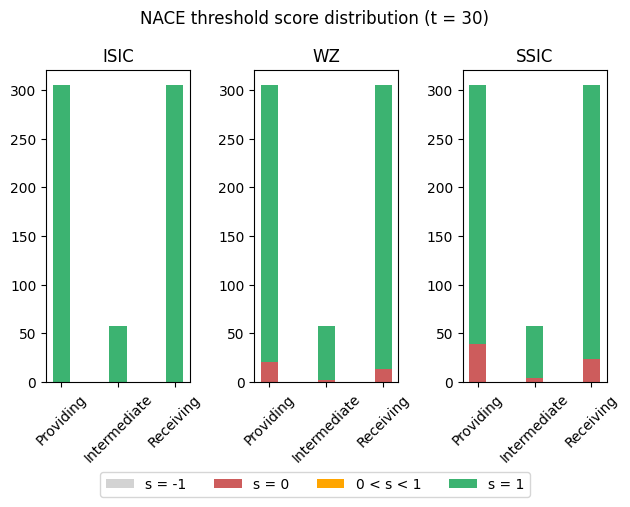

In [49]:
fig, axs = plt.subplots(ncols=len(NON_NACE_STDS))

# Add subplots for each standard
for std, ax in zip(NON_NACE_STDS, axs):
    score_subplot(std, ax)

# Add a legend to the figure
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(score_categories), loc="lower center", bbox_to_anchor=[0.5, -0.05])

# Set the title of the figure
fig.suptitle(f"NACE threshold score distribution (t = {DIFF_THRESHOLD})")

# Add enough padding between subplots to prevent overlapping
fig.tight_layout()

plt.show()

##### By industry classification standard

In [50]:
# Function to extract the scores of a given standard
scores_std = lambda std: np.concatenate(scores_by_role(std))

# Function to extract the scores of a set of standards
scores = lambda stds: [scores_std(std) for std in stds]

# Score count breakdown
score_counts_dict = get_counts(scores)(NON_NACE_STDS)

# Score percentage breakdown
score_percents_dict = get_percents(scores)(NON_NACE_STDS)

In [51]:
# Create a subplot based on a given ICS
def score_plot(ax, is_percent=False):
    # x-axis values
    x = [std.value for std in NON_NACE_STDS]
    
    # Obtain the dictionary with the breakdown of values by similarity score
    values_dict = score_percents_dict if is_percent else score_counts_dict
    
    # Initial bar heights
    bottom = np.zeros(len(x))
    
    # Looping through each category ('s = 0', '0 < s < 1', 's = 1')
    for category, values in values_dict.items():
        # Add bars for each category for all standards ('ISIC', 'WZ', 'SSIC')
        ax.bar(x, values, bar_width, color=bar_colors[category], label=category, bottom=bottom)
        
        # Increment the base bar heights
        bottom += values
    
    # If the type of plot is a percentage plot,
    if is_percent:
        # format the y-axis to be percentage values
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

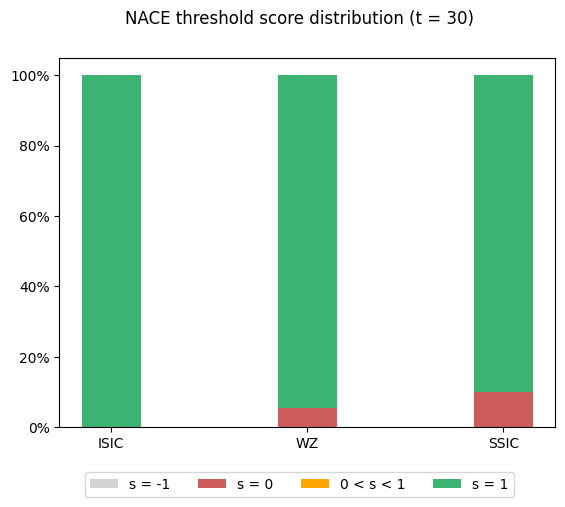

In [52]:
fig, ax = plt.subplots()

# Add bars to the figure
score_plot(ax, is_percent=True)

# Add a legend to the figure
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(score_categories), loc="lower center", bbox_to_anchor=[0.5, -0.05])

# Set the title of the figure
fig.suptitle(f"NACE threshold score distribution (t = {DIFF_THRESHOLD})")

plt.show()

### 4. Exporting results to Excel

In [53]:
with pd.ExcelWriter(f"{EXPORTS_PATH}/Exchanges-database Maestri_new.xlsx") as writer:
    for i in range(len(maestri_dfs)):
        role = MAESTRI_ROLES[i]
        df = maestri_dfs[i]
        
        df.to_excel(writer, sheet_name=role, index=False)
        worksheet = writer.sheets[role]
        workbook = writer.book
        
        format = workbook.add_format()
        format.set_align('left')
        format.set_align('vcenter')
        
        # Loop through all columns
        for index, col in enumerate(df):
            series = df[col]
            max_len = max((
                series.astype(str).map(len).max(),  # Length of largest item
                len(str(series.name))               # Length of column name/header
            ))
            
            # Set column width
            worksheet.set_column(index, index, max_len, format)